In [7]:
!python --version
!pip --version
!pip install tensorflow
!pip install numpy
!pip install gradio
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

Python 3.10.16
pip 25.0 from C:\Users\sav13\anaconda3\anaconda\envs\tf-env\lib\site-packages\pip (python 3.10)



###  Core Libraries
- `tensorflow`: For deep learning model building and training.
- `numpy`: For numerical operations and array manipulation.
- `matplotlib.pyplot`: For plotting training curves and results.


In [8]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations


###  Format: Folder-based image classification dataset  
- `Train/`: Images used for training the model  
- `Test/`: Images used for model evaluation  
- `Validation/`: Images used to fine-tune and validate the model  


In [11]:
testpath= r'C:\Users\sav13\OneDrive\Desktop\E-Waste classification dataset\modified-dataset\test'
trainpath= r'C:\Users\sav13\OneDrive\Desktop\E-Waste classification dataset\modified-dataset\train'
validpath = r'C:\Users\sav13\OneDrive\Desktop\E-Waste classification dataset\modified-dataset\val'

In [41]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (224,224), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [42]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (224,224), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [43]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (224,224), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [44]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


### Visualize sample images from each class.

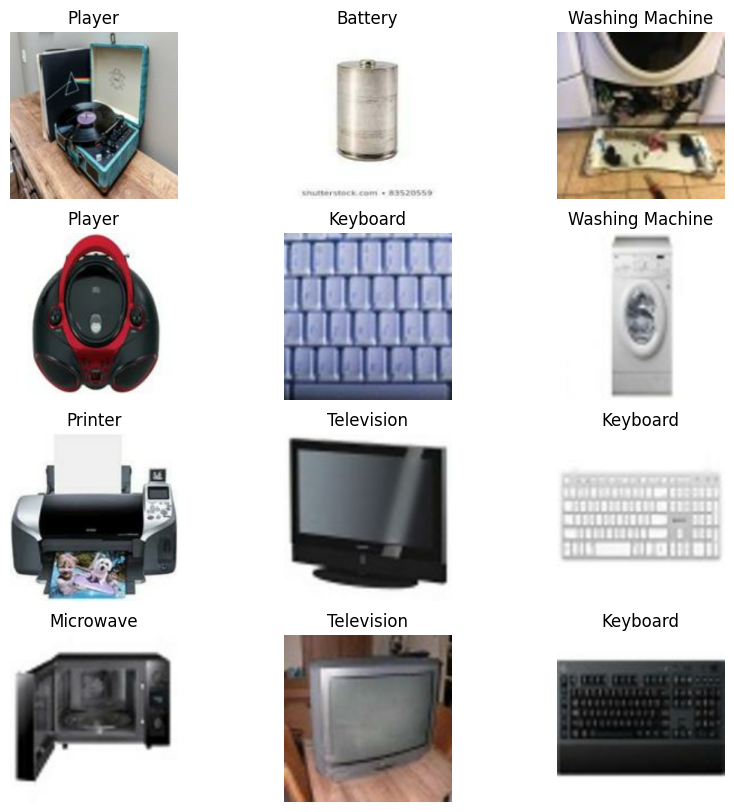

In [45]:

# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")


- ## Check the number of images per class to ensure balance
- ## Understand image properties like Image dimensions, Class labels


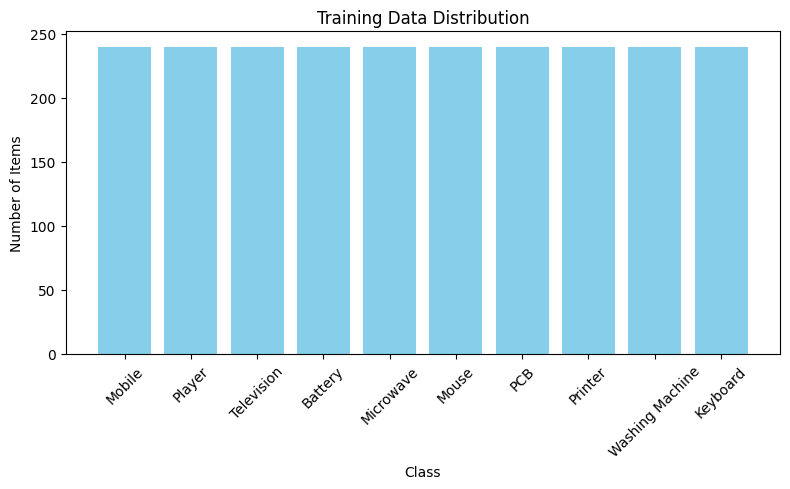

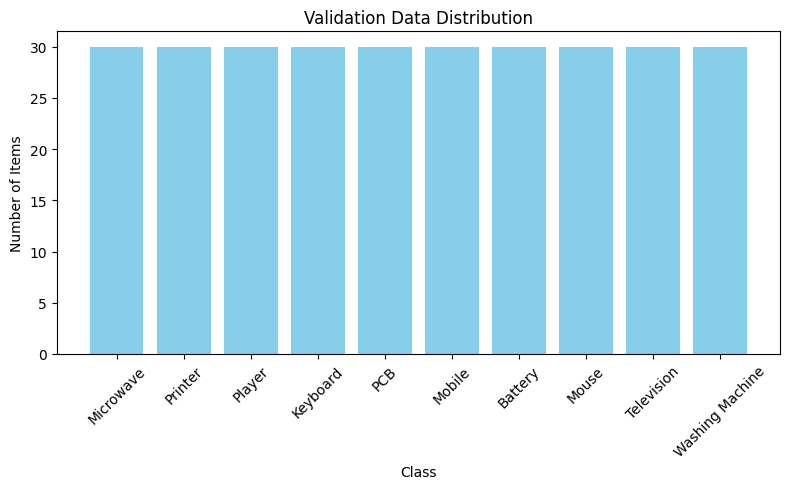

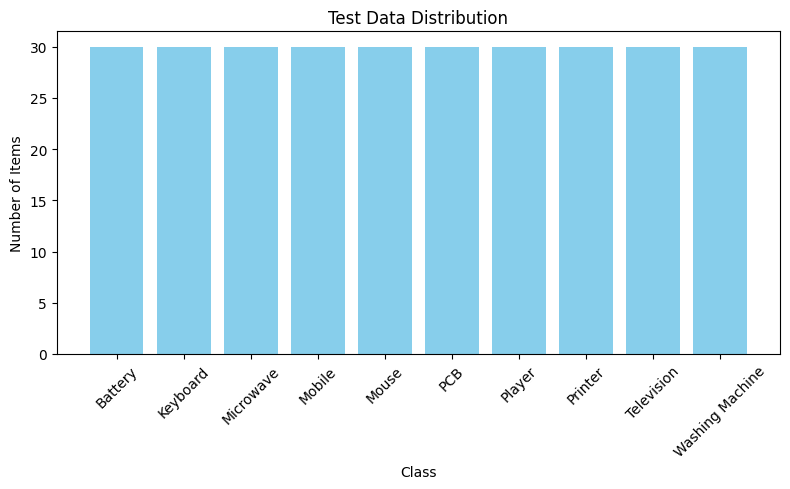

In [57]:
import matplotlib.pyplot as plt

def plot_class_distribution(dataset, title="Class Distribution"):
    class_counts = {}

    # Count samples per class
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = dataset.class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Prepare for plotting
    class_names = list(class_counts.keys())
    counts = list(class_counts.values())

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(class_names, counts, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Items")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Generate plots for train, validation, and test datasets
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")



## 2.  Data Preprocessing / Preparation
- Resize and rescale images.
- Apply data augmentation (e.g., `RandomFlip`, `RandomRotation`, `RandomZoom`) to improve generalization.
- Normalize images (using `preprocess_input` if using pre-trained models like EfficientNet).

In [58]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


## 3.  Model Selection
- Choose a base model: Custom CNN or Transfer Learning (e.g., `EfficientNetV2B0`).
- Decide whether to use pre-trained weights (e.g., ImageNet).
- Define whether layers should be trainable or frozen during initial training.

In [59]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False


## 4.  Model Training
- Build the model architecture using `Sequential` or Functional API.
- Compile the model with loss function ( `sparse_categorical_crossentropy`), optimizer (e.g., `Adam`), and evaluation metrics (`accuracy`).

## 5.  Model Tuning and Optimization
- Tune hyperparameters: learning rate, batch size, number of layers, dropout rate.
- Use callbacks: `EarlyStopping`, 
- Optionally perform fine-tuning on pre-trained models by unfreezing some layers.

In [60]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

###  Callbacks
- `EarlyStopping`: To stop training when validation performance stops improving.

In [65]:
# Define an EarlyStopping callback to stop training when validation loss stops improving

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best_e_waste_model.keras', save_best_only=True, monitor='val_accuracy')
early_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)



### Train the model using `.fit()` with appropriate `epochs`, `batch_size`, and callbacks like `EarlyStopping`.

In [66]:
# Set the number of epochs to train the model
epochs = 20

# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    batch_size=100,                 # Number of samples per gradient update
    callbacks=[checkpoint_cb, early_cb, reduce_lr_cb]               # List of callbacks to apply during training (e.g., early stopping)
)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - Accuracy: 0.8472 - loss: 0.8273 - val_Accuracy: 0.9367 - val_loss: 0.3186 - learning_rate: 1.0000e-04
Epoch 2/20


c:\Users\sav13\anaconda3\anaconda\envs\tf-env\lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - Accuracy: 0.9206 - loss: 0.3361 - val_Accuracy: 0.9567 - val_loss: 0.1843 - learning_rate: 1.0000e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - Accuracy: 0.9440 - loss: 0.2202 - val_Accuracy: 0.9633 - val_loss: 0.1373 - learning_rate: 1.0000e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - Accuracy: 0.9534 - loss: 0.1588 - val_Accuracy: 0.9667 - val_loss: 0.1187 - learning_rate: 1.0000e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - Accuracy: 0.9751 - loss: 0.1149 - val_Accuracy: 0.9700 - val_loss: 0.1057 - learning_rate: 1.0000e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - Accuracy: 0.9783 - loss: 0.0856 - val_Accuracy: 0.9867 - val_loss: 0.0936 - learning_rate: 1.0000e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - Accuracy: 0.9897 - loss: 0.0684 - val_Accuracy: 0.9733 - val_loss: 0.0934 - learning_rate: 1.0000e-04
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - Accuracy: 0.9887 - loss: 0.0

### Model Architechure of EfficientNETV2

In [67]:
model.summary() # Print the architecture summary of the  model

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)

In [68]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ input_layer_9[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          0 │ rescaling_3[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,155,648 (19.67 MB)

 Non-trainable params: 763,664 (2.91 MB)

# Model Performance Visualization: Accuracy & Loss Trends

In [70]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

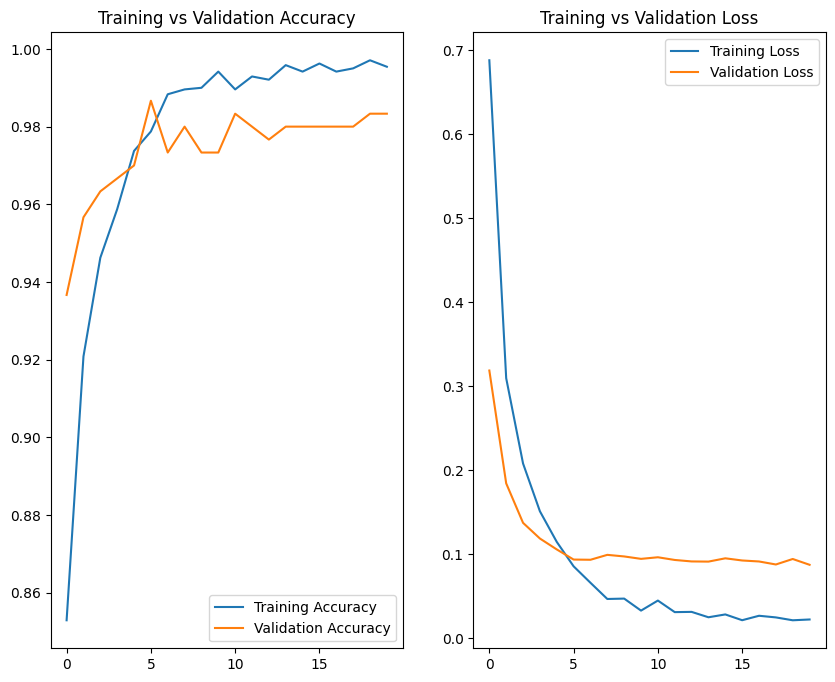

In [71]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots


## 6.  Model Evaluation
- Plot training and validation accuracy/loss curves.
- Evaluate model performance on validation or test set.
- Use metrics like:
  - **Confusion Matrix**
  - **Classification Report** (Precision, Recall, F1-score)
  - `confusion_matrix`, `classification_report`: To evaluate the model's classification performance.




In [72]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 695ms/step - Accuracy: 0.9775 - loss: 0.0660
Test accuracy is0.9700, Test loss is 0.0860


In [73]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)                           

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))                            
print(classification_report(y_true, y_pred))                     


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 815ms/step
[[29  0  0  0  0  1  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  0  1  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 1  0  1  0  0  0 28  0  0  0]
 [ 0  0  0  0  0  0  2 28  0  0]
 [ 0  0  2  0  0  0  1  0 27  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       1.00      1.00      1.00        30
           2       0.91      0.97      0.94        30
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        30
           5       0.97      1.00      0.98        30
           6       0.90      0.93      0.92        30
           7       1.00      0.93      0.97        30
           8       0.96      0.90      0.93        30
           9       1.00      1.00      1.00        30

    accuracy                   

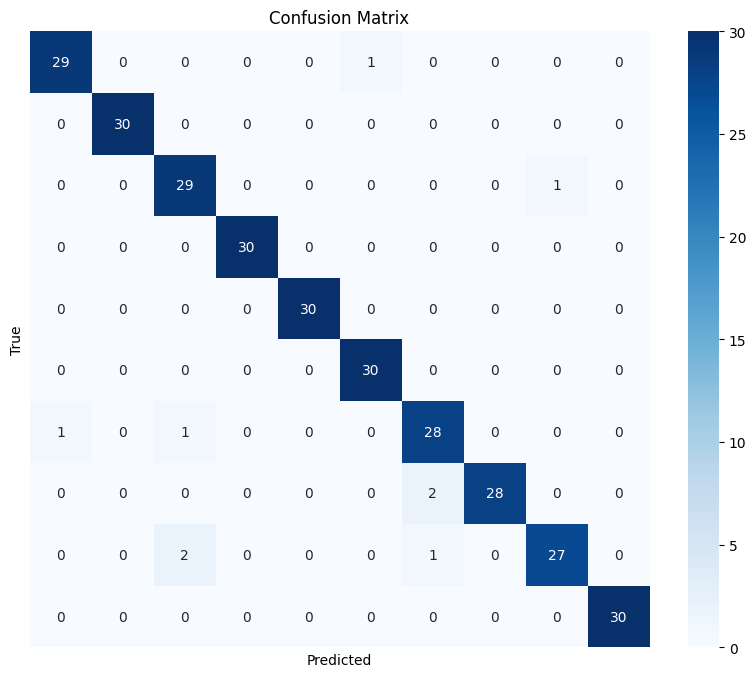

In [74]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot


## 7.  Final Testing and Save the Model
- Evaluate the final model on the unseen **test dataset**.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


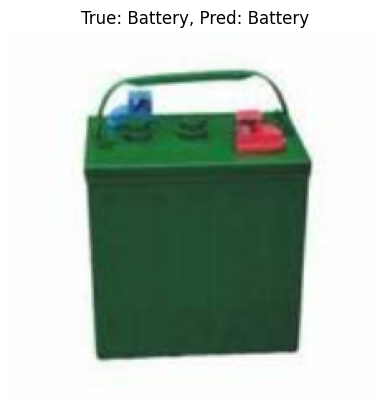

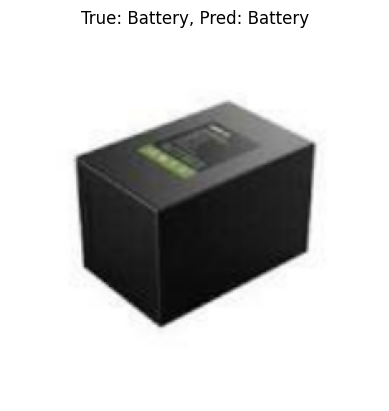

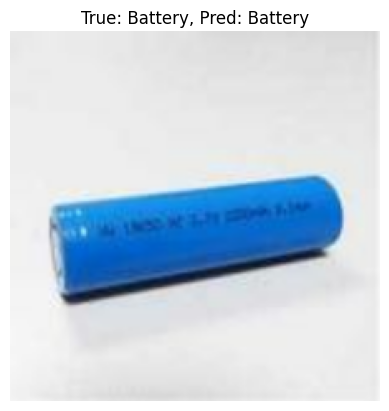

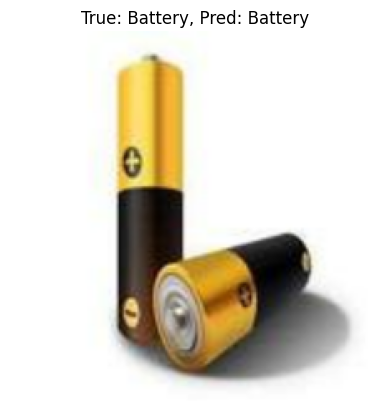

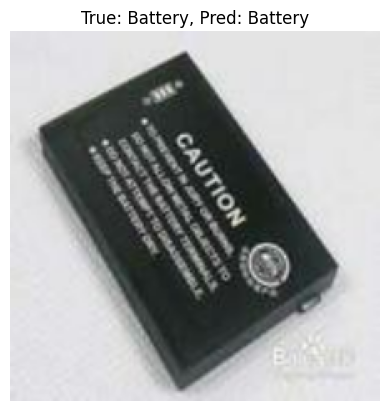

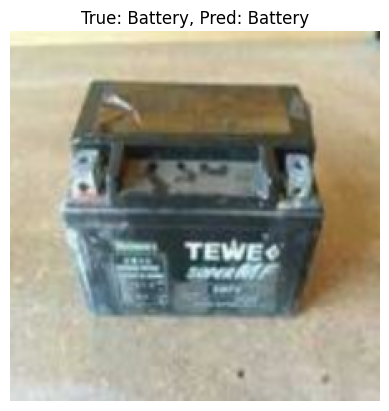

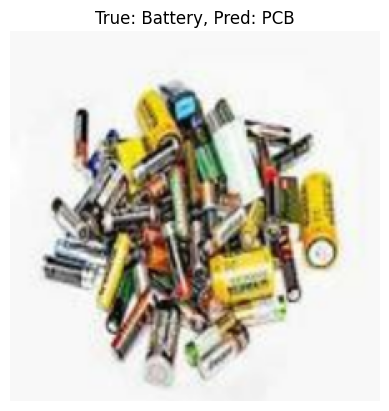

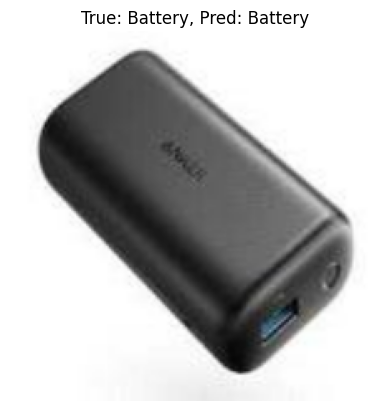

In [75]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()                                                          # Show image



**Save the trained model using `model.save()` or `save_model()` for future inference.**

In [76]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

In [77]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')


## 8.  Model Deployment (Optional)
- Create a web interface using **Gradio**.
- Load the saved model and preprocess input images before prediction.

### 🌐 Gradio Interface and Preprocessing
- `gr`: To build a web interface for the model.
- `PIL.Image`: For handling image input in Gradio.
- `preprocess_input`: Preprocessing method for EfficientNet.
- `load_model`: For loading a saved model for inference.


In [82]:
disposal_map = {
    'Battery': 'Dispose in Hazardous Waste Bin',
    'Keyboard': 'Recycle at E-Waste Center',
    'Microwave': 'Recycle at E-Waste Center',
    'Mobile': 'Return to E-Waste Collection Center',
    'Mouse': 'Recycle at E-Waste Center',
    'PCB': 'Recycle with Specialist E-Waste Recycler',
    'Player': 'Recycle at E-Waste Center',
    'Printer': 'Return to Manufacturer or E-Waste Center',
    'Television': 'Recycle at Large Appliance Facility',
    'Washing Machine': 'Recycle at Large Appliance Facility'
}

from tensorflow.keras.applications.efficientnet import preprocess_input

def classify_image(img):
    img = img.resize((224, 224))
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)   # ✅ Use EfficientNet-specific preprocessing
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    index = np.argmax(prediction)
    confidence = prediction[0][index]
    class_name = class_names[index]
    disposal_method = disposal_map.get(class_name, "General E-Waste Disposal")
    result = f"Predicted: {class_name} (Confidence: {confidence:.2f})\\nRecommended Disposal: {disposal_method}"
    if confidence < 0.7:
        result += "\\n⚠️ Low confidence, verify manually."
    return result


def plot_prediction_bars(prediction):
    plt.figure(figsize=(8, 4))
    plt.bar(class_names, prediction[0], color='skyblue')
    plt.ylabel('Probability')
    plt.title('Prediction Confidence for Each Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="E-Waste Classifier with Disposal Guidance",
    description="Upload an e-waste image to classify its category with disposal instructions and confidence checks."
)
iface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://32d784f3f37250e9ee.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
